## Experiment 1 - ARIMA for time series

### 1. Read data

In [1]:
import pandas as pd

# Read the data into a DataFrame'
df_train = pd.read_csv("../../data/raw/sales_train.csv")
df_test = pd.read_csv("../../data/raw/sales_test.csv")

In [2]:
# Drop unnecessary columns
df_train.drop(["id", "dept_id", "cat_id", "state_id"], inplace=True, axis=1)

In [3]:
# Load the "item_id" column from the training data
id_columns = df_train[["item_id", "store_id"]]

# Join the "item_id" and "store_id" columns to the test data
df_test = pd.concat([id_columns, df_test], axis=1)

In [5]:
df_train.shape

(30490, 1543)

### 2. Transform data

In [4]:
# pivot data to get days as data samples
df_train_trans = df_train.melt(id_vars=['item_id', 'store_id'], var_name='d', value_name='units_sold')

# Peform same for test data
df_test_trans = df_test.melt(id_vars=['item_id', 'store_id'], var_name='d', value_name='units_sold')

del df_train
del df_test

In [5]:
df_train_trans.head()

,item_id,store_id,d,units_sold
0,HOBBIES_1_001,CA_1,d_1,0
1,HOBBIES_1_002,CA_1,d_1,0
2,HOBBIES_1_003,CA_1,d_1,0
3,HOBBIES_1_004,CA_1,d_1,0
4,HOBBIES_1_005,CA_1,d_1,0


In [6]:
df_train_trans.shape

(46985090, 4)

### 3. Feature Engineering

In [7]:
import sys
sys.path.append('../../src/data')

# import class from merge file
from merge import Merger
df_train_merged = Merger().merge_df(df_train_trans)
df_test_merged = Merger().merge_df(df_test_trans)

In [8]:
df_train_merged.head()

,item_id,store_id,date,sell_price,revenue
0,HOBBIES_1_008,CA_1,2011-01-29,0.46,5.52
1,HOBBIES_1_008,CA_1,2011-01-30,0.46,6.90
2,HOBBIES_1_008,CA_1,2011-01-31,0.46,0.00
3,HOBBIES_1_008,CA_1,2011-02-01,0.46,0.00
4,HOBBIES_1_008,CA_1,2011-02-02,0.46,0.00


In [9]:
del df_train_trans
del df_test_trans

In [10]:
df_train_merged.shape

(34720691, 5)

In [11]:
df_train_cleaned = df_train_merged.groupby('date')['revenue'].sum().reset_index()
df_test_cleaned = df_test_merged.groupby('date')['revenue'].sum().reset_index()

In [12]:
del df_train_merged
del df_test_merged

In [13]:
df_train_cleaned.head()

,date,revenue
0,2011-01-29,81650.61
1,2011-01-30,78970.57
2,2011-01-31,57706.91
3,2011-02-01,60761.20
4,2011-02-02,46959.95


In [14]:
df_test_cleaned.head()

,date,revenue
0,2015-04-19,141758.65
1,2015-04-20,105781.23
2,2015-04-21,96606.05
3,2015-04-22,95237.65
4,2015-04-23,96460.08


### 4. Data Cleaning - Check for outliers

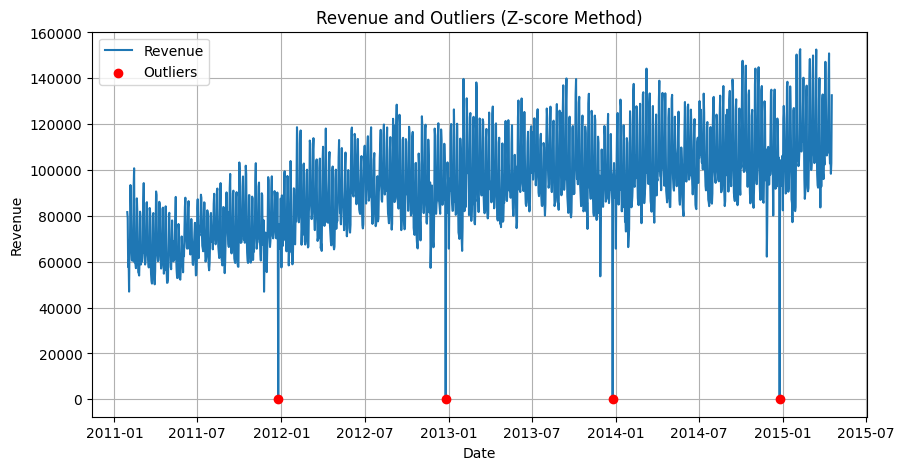

In [15]:
from scipy import stats
import matplotlib.pyplot as plt

# Calculate Z-scores for the 'revenue' column
z_scores = stats.zscore(df_train_cleaned['revenue'])

# Define a Z-score threshold to identify outliers
z_score_threshold = 3  # You can adjust this threshold as needed

# Identify outliers based on the Z-score
outliers = df_train_cleaned[abs(z_scores) > z_score_threshold]

# Create a plot of outliers
plt.figure(figsize=(10, 5))
plt.plot(df_train_cleaned['date'], df_train_cleaned['revenue'], label='Revenue')
plt.scatter(outliers['date'], outliers['revenue'], color='red', marker='o', label='Outliers', zorder=5)
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Revenue and Outliers (Z-score Method)')
plt.legend()
plt.grid()
plt.show()

In [16]:
df_train_cleaned = df_train_cleaned[abs(z_scores) <= z_score_threshold]

In [17]:
df_train_cleaned.shape

(1537, 2)

In [21]:
df_test_cleaned.shape

(400, 2)

In [19]:
### Check if there's any zero sales

In [18]:
(df_train_cleaned[df_train_cleaned['revenue'] == 0]['date']).any()

False

In [20]:
(df_test_cleaned[df_test_cleaned['revenue'] == 0]['date']).any()

False

No zero sales for any date present in the data. Good!

### Save the interim dataframe into a pickle file, uses less memory

In [23]:
df_train_cleaned.to_pickle("../../data/interim/forecasting/train_cleaned.pkl")  
df_test_cleaned.to_pickle("../../data/interim/forecasting/test_cleaned.pkl")  

### Load the processed dataframe if kernel restarts

In [1]:
import pandas as pd
df_train = pd.read_pickle("../../data/interim/forecasting/train_cleaned.pkl")
df_test = pd.read_pickle("../../data/interim/forecasting/test_cleaned.pkl")

### 5. Modelling

In [2]:
# Import necessary libraries
import os
import glob
import pickle
import warnings
import numpy as np
import seaborn as sns
from numpy import mean, std
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Set 'date' as the index
df_train.set_index('date', inplace=True)
df_test.set_index('date', inplace=True)

### 5.1 Baseline Model - Exponentially Weighted Moving Average (EWMA)

In [16]:
# Calculate the EWMA on the Training Data
train_pred_ewma = df_train['revenue'].ewm(alpha=0.1).mean()

# Calculate the EWMA on the Test Data
test_pred_ewma = df_test['revenue'].ewm(alpha=0.1).mean()

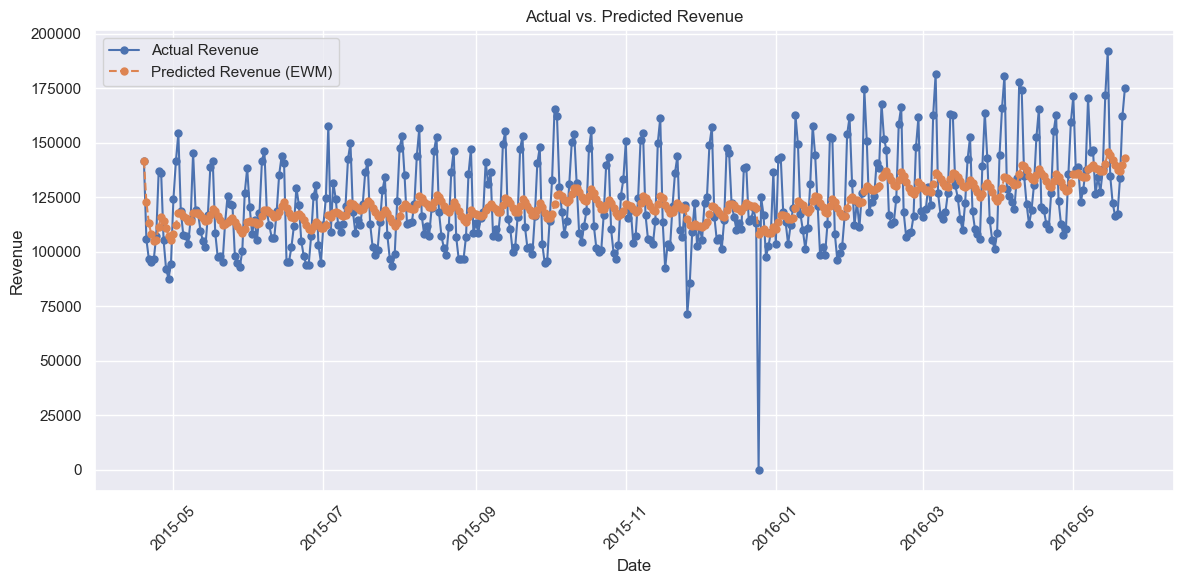

In [17]:
# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the actual revenue
ax.plot(df_test['revenue'], label='Actual Revenue', linestyle='-', marker='o', markersize=5)

# Plot the predicted revenue using Exponential Weighted Mean
ax.plot(test_pred_ewma, label='Predicted Revenue (EWM)', linestyle='--', marker='o', markersize=5)

# Add labels and a legend
ax.set_xlabel('Date')
ax.set_ylabel('Revenue')
ax.set_title('Actual vs. Predicted Revenue')
ax.legend()
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


In [18]:
# importing means squared error metrics package from sklearn
from sklearn.metrics import mean_squared_error

# Calculating RMSE on train and test sets
train_rmse_ewma = np.sqrt(mean_squared_error(df_train["revenue"], train_pred_ewma))
print("RMSE for Exponential Weighted Moving Average on train data:", train_rmse_ewma)

test_rmse_ewma = np.sqrt(mean_squared_error(df_test["revenue"], test_pred_ewma))
print("RMSE for Exponential Weighted Moving Average on test data:", test_rmse_ewma)

RMSE for Exponential Weighted Moving Average on train data: 14174.62109679122
RMSE for Exponential Weighted Moving Average on test data: 18781.731632668972


### 5.2 ARIMA model

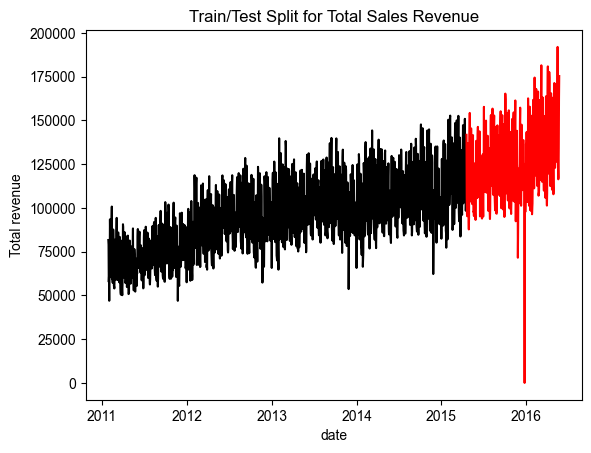

In [4]:
#Plot train and test sets
plt.plot(df_train["revenue"], color = "black")
plt.plot(df_test["revenue"], color = "red")
plt.title("Train/Test Split for Total Sales Revenue")
plt.ylabel("Total revenue")
plt.xlabel('date')
sns.set()
plt.show()

In [5]:
from pmdarima import auto_arima
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import BoxCoxEndogTransformer

ar_pipeline = Pipeline([
            ("boxcox", BoxCoxEndogTransformer()),
            ("model", auto_arima(df_train["revenue"], trace=True, error_action='ignore',
                             suppress_warnings=True, seasonal=True, m=12, n_jobs=-1, stepwise=True))
            ])

ar_pipeline.fit(df_train["revenue"])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=32759.643, Time=2.44 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=33928.716, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=33768.603, Time=0.23 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=33675.976, Time=0.75 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=33926.723, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=32800.036, Time=1.81 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=32768.683, Time=1.87 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=33138.264, Time=5.54 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=inf, Time=8.18 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=32955.947, Time=0.41 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=32779.893, Time=4.68 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=32745.923, Time=9.86 sec
 ARIMA(1,1,2)(2,0,0)[12] intercept   : AIC=33147.905, Time=6.35 sec
 ARIMA(2,1,1)(2,0,0)[12] intercept   : AIC=33042.109, Time=2.89 sec
 ARIMA(3,1,

Pipeline(steps=[('boxcox', BoxCoxEndogTransformer()),
                ('model',
                 ARIMA(order=(5, 1, 5), scoring_args={},
                       seasonal_order=(2, 0, 2, 12), suppress_warnings=True))])

In [6]:
# importing mean squared error metrics package from sklearn
from sklearn.metrics import mean_squared_error

# Evaluate the model on the Train & testing data
train_pred_arima = ar_pipeline.predict(n_periods=len(df_train))
train_rmse_arima = np.sqrt(mean_squared_error(df_train['revenue'], train_pred_arima))
print("RMSE for ARIMA on Train data:", train_rmse_arima)

test_pred_arima = ar_pipeline.predict(n_periods=len(df_test))
test_rmse_arima = np.sqrt(mean_squared_error(df_test['revenue'], test_pred_arima))
print("RMSE for ARIMA on Test data:", test_rmse_arima)

RMSE for ARIMA on Train data: 56688.420182774295
RMSE for ARIMA on Test data: 17238.09947894374


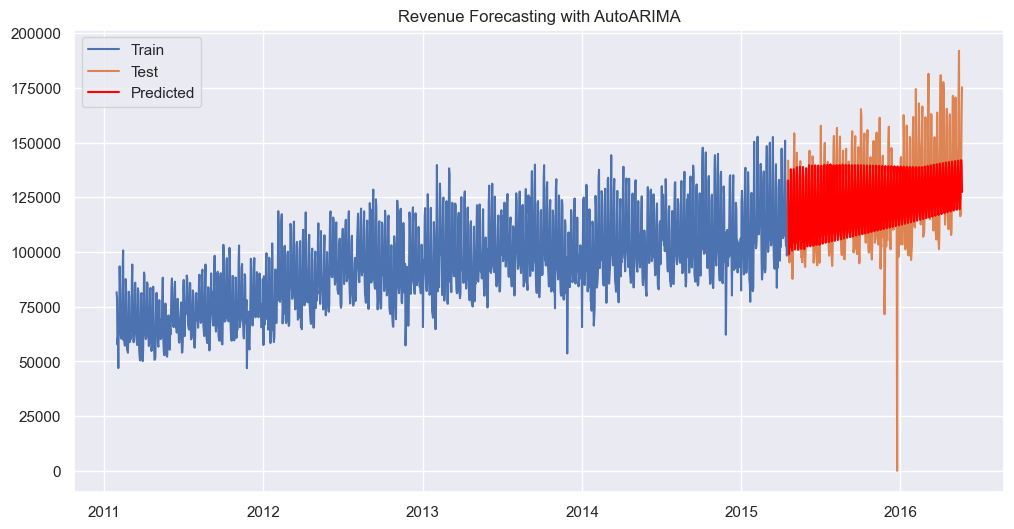

In [7]:
# Plot the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(df_train.index, df_train['revenue'], label='Train')
plt.plot(df_test.index, df_test['revenue'], label='Test')
plt.plot(df_test.index, test_pred_arima, label='Predicted', color='red')
plt.legend(loc='best')
plt.title('Revenue Forecasting with AutoARIMA')
plt.show()

### Make forecast of next 7 days with the test data

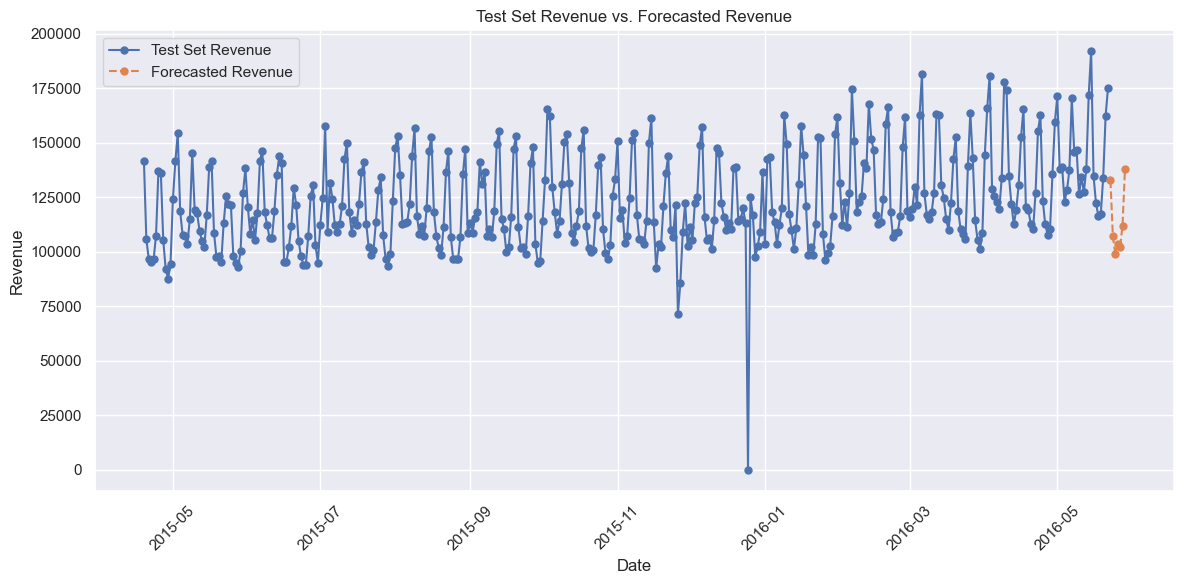

In [9]:
# Predict the next 7 days' revenue
forecast_steps = 7
forecast = ar_pipeline.predict(n_periods = forecast_steps)

# Create a date range for the next 7 days
forecast_dates = pd.date_range(start=df_test.index[-1] + pd.DateOffset(days=1), periods=7, freq='D')

# Create a DataFrame for the forecasted data
forecast_df = pd.DataFrame({'date': forecast_dates, 'forecasted_revenue': forecast})
forecast_df.set_index('date', inplace=True)

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the test set revenue
ax.plot(df_test.index, df_test['revenue'], label='Test Set Revenue', linestyle='-', marker='o', markersize=5)

# Plot the forecasted revenue
ax.plot(forecast_df.index, forecast_df['forecasted_revenue'], label='Forecasted Revenue', linestyle='--', marker='o', markersize=5)

# Add labels and a legend
ax.set_xlabel('Date')
ax.set_ylabel('Revenue')
ax.set_title('Test Set Revenue vs. Forecasted Revenue')
ax.legend()

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


In [21]:
np.round(forecast, decimals=2)

array([132709.45, 107090.05,  98906.7 , 103565.62, 102304.07, 112020.43,
       137847.38])

### Save model for deployment

In [10]:
from joblib import dump

dump(ar_pipeline, '../../models/forecasting/arima.joblib')

['../../models/forecasting/arima.joblib']

### 5.3 SARIMAX model
We will use the best parameters derived from auto arima (while training) to train SARIMAX: <br> 
ARIMA Order (p, d, q) = (5,1,5)
Seasonal Order (P, Q, D) = (2,0,2)

In [12]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from statsmodels.tsa.seasonal import seasonal_decompose

# Custom transformer to perform seasonal decomposition
class SeasonalDecomposer(BaseEstimator, TransformerMixin):
    def __init__(self, period=12):
        self.period = period
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        decomposition = seasonal_decompose(X['revenue'], model='additive', period=self.period)
        X['trend'] = decomposition.trend
        X['seasonal'] = decomposition.seasonal
        X['residual'] = decomposition.resid
        return X

# Define the SARIMA model
class SARIMAModel(BaseEstimator, TransformerMixin):
    def __init__(self, order=(5,1,5), seasonal_order=(2,0,2,12)):
        self.order = order
        self.seasonal_order = seasonal_order
    
    def fit(self, X, y=None):
        self.model = SARIMAX(X['revenue'],
                             order=self.order,
                             seasonal_order=self.seasonal_order,
                             enforce_stationarity=False,
                             enforce_invertibility=False)
        self.results = self.model.fit()
        return self
    
    def transform(self, X):
        return X
    
    def predict(self, X):
        predictions = self.results.get_forecast(steps=len(X))
        return predictions.predicted_mean

# Create a pipeline
sarx_pipeline = Pipeline([
    ('decomposer', SeasonalDecomposer(period=12)),
    ('sarima', SARIMAModel(order=(5,1,5), seasonal_order=(2,0,2,12)))
])

# Fit the pipeline on training data
sarx_pipeline.fit(df_train)

/opt/homebrew/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02211D+01    |proj g|=  2.42443D-01


 This problem is unconstrained.



At iterate    5    f=  1.01981D+01    |proj g|=  1.78406D-01

At iterate   10    f=  1.01913D+01    |proj g|=  3.52216D-02

At iterate   15    f=  1.01829D+01    |proj g|=  9.50545D-02

At iterate   20    f=  1.01803D+01    |proj g|=  6.50222D-02

At iterate   25    f=  1.01671D+01    |proj g|=  9.11346D-02

At iterate   30    f=  1.01580D+01    |proj g|=  5.96228D-02

At iterate   35    f=  1.01551D+01    |proj g|=  2.97940D-02

At iterate   40    f=  1.01541D+01    |proj g|=  1.19578D-01

At iterate   45    f=  1.01534D+01    |proj g|=  6.89023D-02


/opt/homebrew/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.01506D+01    |proj g|=  8.07553D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     55      1     0     0   8.076D-02   1.015D+01
  F =   10.150599415718444     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


Pipeline(steps=[('decomposer', SeasonalDecomposer()),
                ('sarima', SARIMAModel())])

In [13]:
# Make predictions on the train & testing data
train_pred_sarimax = sarx_pipeline.predict(df_train)
test_pred_sarimax = sarx_pipeline.predict(df_test)

# Evaluate the SARIMAX model
train_rmse_sarimax = np.sqrt(mean_squared_error(df_train['revenue'], train_pred_sarimax))
print("RMSE for SARIMAX on train set:", train_rmse_sarimax)

test_rmse_sarimax = np.sqrt(mean_squared_error(df_test['revenue'], test_pred_sarimax))
print("RMSE for SARIMAX on test set:", test_rmse_sarimax)

RMSE for SARIMAX on train set: 27509.98973668136
RMSE for SARIMAX on test set: 21173.80770329934


/opt/homebrew/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/homebrew/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


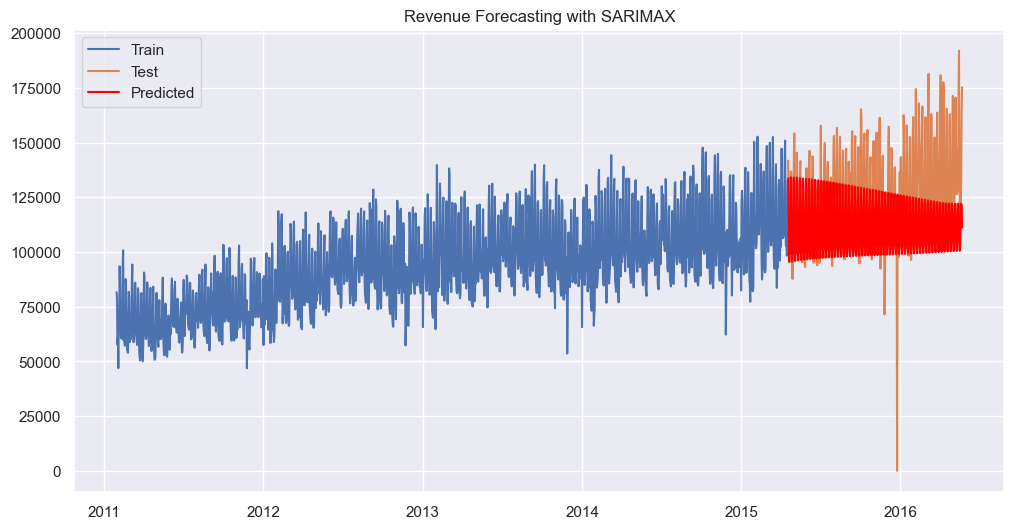

In [14]:
# Plot the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(df_train.index, df_train['revenue'], label='Train')
plt.plot(df_test.index, df_test['revenue'], label='Test')
plt.plot(df_test.index, test_pred_sarimax, label='Predicted', color='red')
plt.legend(loc='best')
plt.title('Revenue Forecasting with SARIMAX')
plt.show()

### 6. Compare results with baseline on test set

In [19]:
# Saving the rmse values into list
results = [['EWMA (baseline)', test_rmse_ewma], ['ARIMA', test_rmse_arima], ['SARIMAX', test_rmse_sarimax]]
  
# Create the pandas DataFrame for results
df_results = pd.DataFrame(results, columns=['Method', 'RMSE'])
df_results

,Method,RMSE
0,EWMA (baseline),18781.731633
1,ARIMA,17238.099479
2,SARIMAX,21173.807703


## Appendix

### Update to the issue with heroku memory exceeded: Will train the model in batches to reduce the model size

In [6]:
from pmdarima import auto_arima
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import BoxCoxEndogTransformer

# Initialize an empty list to store batches
batch_size = 512
batches = []

# Calculate the number of batches
num_batches = int(np.ceil(len(df_train["revenue"]) / batch_size))

# Iterate through the data and create batches
for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = (i + 1) * batch_size
    batch = df_train[start_idx:end_idx]  # Extract a batch of data
    batches.append(batch)

ar_pipeline = Pipeline([
            ("boxcox", BoxCoxEndogTransformer()),
            ("model", auto_arima(df_train["revenue"], trace=True, error_action='ignore',
                             suppress_warnings=True, seasonal=True, m=12, n_jobs=-1, stepwise=True))
            ])

ar_pipeline.fit(batches[0])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=32759.643, Time=2.16 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=33928.716, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=33768.603, Time=0.22 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=33675.976, Time=0.67 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=33926.723, Time=0.03 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=32800.036, Time=1.57 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=32768.683, Time=1.95 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=33138.264, Time=5.09 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=inf, Time=7.14 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=32955.947, Time=0.44 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=32779.893, Time=4.63 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=32745.923, Time=8.97 sec
 ARIMA(1,1,2)(2,0,0)[12] intercept   : AIC=33147.905, Time=5.99 sec
 ARIMA(2,1,1)(2,0,0)[12] intercept   : AIC=33042.109, Time=2.69 sec
 ARIMA(3,1,

Pipeline(steps=[('boxcox', BoxCoxEndogTransformer()),
                ('model',
                 ARIMA(order=(5, 1, 5), scoring_args={},
                       seasonal_order=(2, 0, 2, 12), suppress_warnings=True))])

In [ ]:
for i in range(len(batches)-1):
    ar_pipeline.update(batches[i+1])

### Seasonal Auto Arima with exogenous features - automatically finding the optimal order parameters

In [ ]:
from pmdarima import auto_arima
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

# Custom transformer to perform seasonal decomposition
class SeasonalDecomposer(BaseEstimator, TransformerMixin):
    def __init__(self, period=12):
        self.period = period
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        decomposition = seasonal_decompose(X['revenue'], model='additive', period=self.period)
        X['trend'] = decomposition.trend
        X['seasonal'] = decomposition.seasonal
        X['residual'] = decomposition.resid
        return X

# Define the SARIMA model
class SARIMAModel(BaseEstimator, TransformerMixin):
    def __init__(self, order=(1, 0, 0), seasonal_order=(1, 1, 1, 7)):
        self.order = order
        self.seasonal_order = seasonal_order
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X
    
    def predict(self, X):
        return X

# Create a pipeline with auto_arima and exogenous features
pipeline = Pipeline([
    ('decomposer', SeasonalDecomposer(period=12)),
    ('auto_arima', auto_arima(df_train['revenue'], exogenous = 'seasonal', seasonal=True, m=12))
])

# Fit the pipeline on training data
pipeline.fit(df_train)


In [ ]:
# Build an EMA forecasting model
model = ExponentialSmoothing(train_data['revenue'], trend='add', seasonal='add', seasonal_periods=7)
ema_model = model.fit()

# Evaluate the model on the testing data
predictions = ema_model.forecast(len(test_data))
mse = mean_squared_error(test_data['revenue'], predictions)
print("Mean Squared Error (MSE):", mse)

# Plot the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['revenue'], label='Train')
plt.plot(test_data.index, test_data['revenue'], label='Test')
plt.plot(test_data.index, predictions, label='Predicted', color='red')
plt.legend(loc='best')
plt.title('Revenue Forecasting with EMA')
plt.show()

# Predict the next 7 days' revenue based on an input date
input_date = pd.to_datetime('2023-09-01')  # Replace with your input date
forecast = ema_model.forecast(steps=7, initial=input_date)

# Print the next 7 days' revenue forecast
print("Next 7 Days' Revenue Forecast:")
print(forecast)